# Entrenamiento de Modelos para Detección de Fraude

Este notebook entrena y optimiza varios modelos de machine learning para la detección de fraude en transacciones de tarjetas de crédito.

## Contenido

1. Carga de datos procesados
2. Entrenamiento de modelos base
3. Comparación de modelos base
4. Optimización de hiperparámetros (versión eficiente)
5. Evaluación de modelos optimizados
6. Análisis de características importantes
7. Visualizaciones avanzadas
8. Generación de informes
9. Guardado de modelos

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import time
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    fbeta_score, matthews_corrcoef, cohen_kappa_score
)

# Configurar visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

# Añadir directorio raíz al path para importar módulos personalizados
sys.path.append('..')

# Importar funciones personalizadas
from src.config import (
    RANDOM_STATE, MODELS_DIR, FIGURES_DIR, REPORTS_DIR,
    X_TRAIN_FILE, X_TEST_FILE, Y_TRAIN_FILE, Y_TEST_FILE
)
from src.data_prep import load_processed_data
from src.model_training import (
    get_base_models, get_param_grids, train_base_model, train_all_base_models,
    optimize_hyperparameters, optimize_all_models, evaluate_model,
    compare_models, plot_confusion_matrix, plot_roc_curve,
    plot_precision_recall_curve, save_model, load_model,
    train_and_optimize_pipeline
)
from src.utils import timer_decorator, save_figure

# Nuevas importaciones para visualización y generación de informes
try:
    from src.visualization_helpers import (
        plot_all_confusion_matrices,
        plot_all_roc_curves,
        plot_all_precision_recall_curves,
        create_model_comparison_dashboard,
        plot_model_comparison_heatmap,
        plot_calibration_curves
    )
except ImportError as e:
    print(f"Advertencia: No se pudieron importar todas las funciones de visualización: {e}")
    # Importar solo las funciones disponibles
    from src.visualization_helpers import (
        plot_all_confusion_matrices,
        plot_all_roc_curves,
        plot_all_precision_recall_curves,
        create_model_comparison_dashboard,
        plot_model_comparison_heatmap
    )
    # Definir una función vacía para las que faltan
    def plot_calibration_curves(*args, **kwargs):
        print("La función plot_calibration_curves no está disponible.")
        return None

try:
    from src.generate_report import generate_markdown_report
except ImportError:
    print("Advertencia: No se pudo importar generate_markdown_report")
    # Definir una función vacía
    def generate_markdown_report(*args, **kwargs):
        print("La función generate_markdown_report no está disponible.")
        return None

## 1. Carga de datos procesados

In [2]:
# Cargar datos procesados
print("Cargando datos procesados...")
X_train, X_test, y_train, y_test, feature_names = load_processed_data()

print(f"\nDimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Dimensiones de y_train: {y_train.shape}")
print(f"Dimensiones de y_test: {y_test.shape}")

# Verificar distribución de clases
train_class_dist = pd.Series(y_train).value_counts(normalize=True) * 100
test_class_dist = pd.Series(y_test).value_counts(normalize=True) * 100

print("\nDistribución de clases en conjunto de entrenamiento:")
for cls, pct in train_class_dist.items():
    print(f"  Clase {cls}: {pct:.2f}%")

print("\nDistribución de clases en conjunto de prueba:")
for cls, pct in test_class_dist.items():
    print(f"  Clase {cls}: {pct:.2f}%")

Cargando datos procesados...
Cargando datos procesados...
Datos cargados:
X_train: (453204, 42)
X_test: (56746, 42)
y_train: (453204,)
y_test: (56746,)
Función load_processed_data ejecutada en 4.47 segundos

Dimensiones de X_train: (453204, 42)
Dimensiones de X_test: (56746, 42)
Dimensiones de y_train: (453204,)
Dimensiones de y_test: (56746,)

Distribución de clases en conjunto de entrenamiento:
  Clase 0: 50.00%
  Clase 1: 50.00%

Distribución de clases en conjunto de prueba:
  Clase 0: 99.83%
  Clase 1: 0.17%


Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\class_distribution.png


<Figure size 1000x600 with 0 Axes>

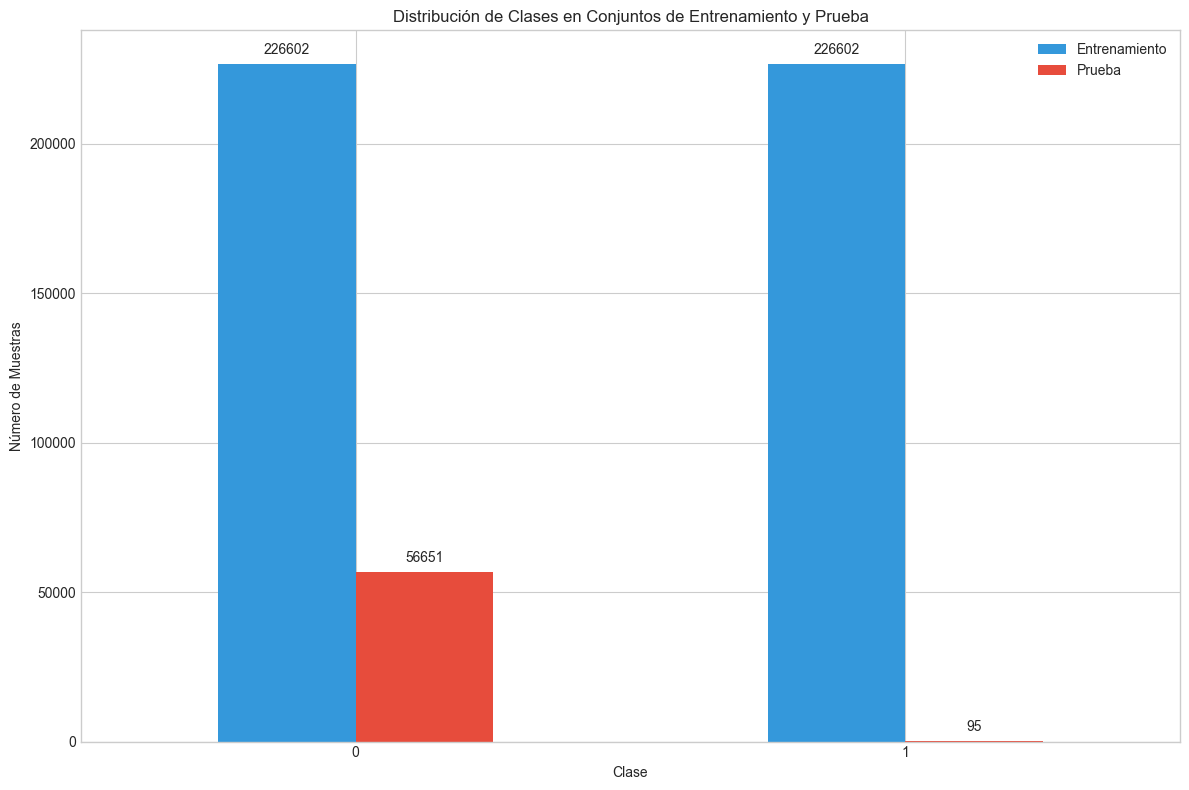

In [3]:
# Visualizar distribución de clases
plt.figure(figsize=(10, 6))
train_counts = pd.Series(y_train).value_counts()
test_counts = pd.Series(y_test).value_counts()

# Crear DataFrame para visualización
class_df = pd.DataFrame({
    'Entrenamiento': train_counts,
    'Prueba': test_counts
})

# Graficar
ax = class_df.plot(kind='bar', color=['#3498db', '#e74c3c'])
plt.title('Distribución de Clases en Conjuntos de Entrenamiento y Prueba')
plt.xlabel('Clase')
plt.ylabel('Número de Muestras')
plt.xticks(rotation=0)

# Añadir etiquetas de valores
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom',
                xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()

# Guardar figura
try:
    save_figure('class_distribution.png')
except Exception as e:
    print(f"Error al guardar figura: {e}")
    # Alternativa si save_figure falla
    plt.savefig(os.path.join('..', 'reports', 'figures', 'class_distribution.png'), dpi=300, bbox_inches='tight')

plt.show()

## 2. Entrenamiento de modelos base

In [4]:
# Obtener modelos base
print("Obteniendo modelos base...")
base_models = get_base_models()

print("\nModelos base disponibles:")
for name in base_models.keys():
    print(f"  - {name}")

Obteniendo modelos base...
Función get_base_models ejecutada en 0.00 segundos

Modelos base disponibles:
  - logistic_regression
  - random_forest
  - gradient_boosting
  - xgboost
  - lightgbm


Entrenando todos los modelos base...
Función get_base_models ejecutada en 0.00 segundos

Entrenando modelo base: logistic_regression
Función evaluate_model ejecutada en 0.05 segundos
Función train_base_model ejecutada en 2.86 segundos
  Accuracy: 0.9906
  Precision: 0.1360
  Recall: 0.8632
  F1 Score: 0.2350
  AUC-ROC: 0.9592

Entrenando modelo base: random_forest
Función evaluate_model ejecutada en 0.25 segundos
Función train_base_model ejecutada en 64.65 segundos
  Accuracy: 0.9995
  Precision: 0.9342
  Recall: 0.7474
  F1 Score: 0.8304
  AUC-ROC: 0.9564

Entrenando modelo base: gradient_boosting
Función evaluate_model ejecutada en 0.20 segundos
Función train_base_model ejecutada en 816.85 segundos
  Accuracy: 0.9974
  Precision: 0.3738
  Recall: 0.8105
  F1 Score: 0.5116
  AUC-ROC: 0.9590

Entrenando modelo base: xgboost
Función evaluate_model ejecutada en 0.13 segundos
Función train_base_model ejecutada en 3.39 segundos
  Accuracy: 0.9995
  Precision: 0.9259
  Recall: 0.7895
  F1 S

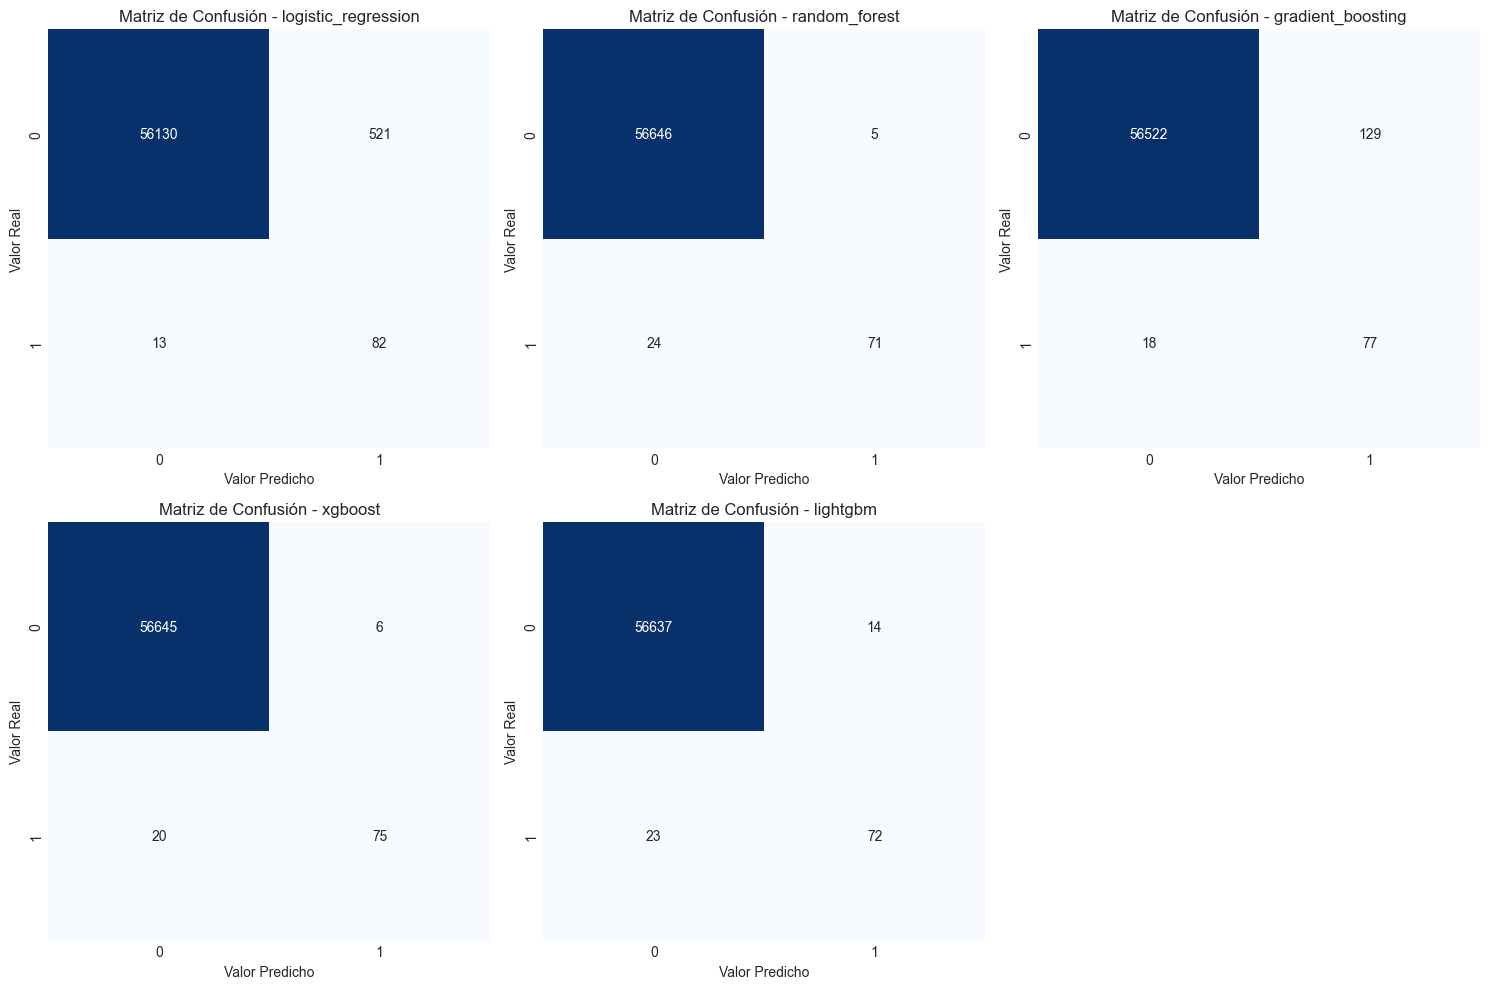

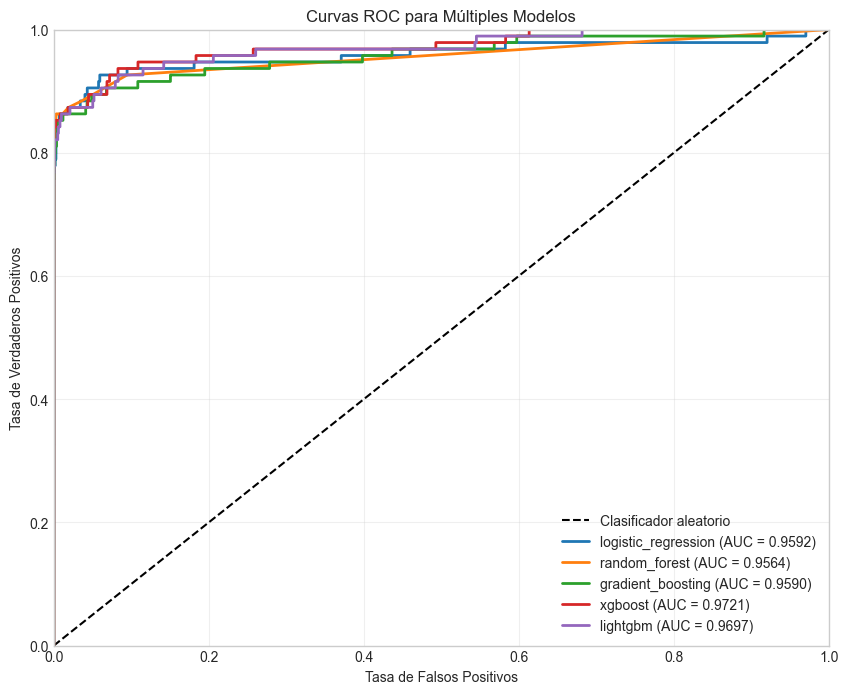

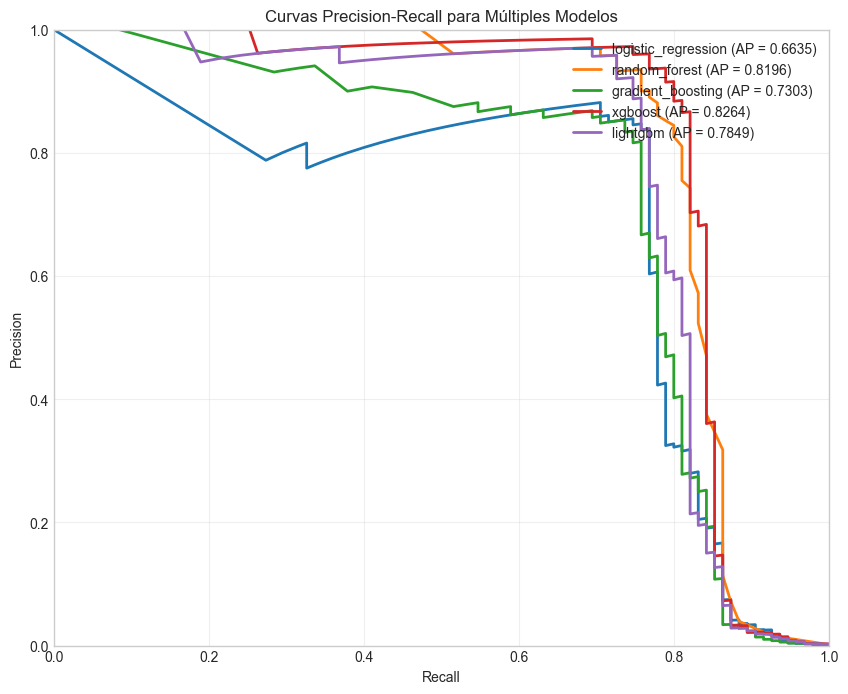

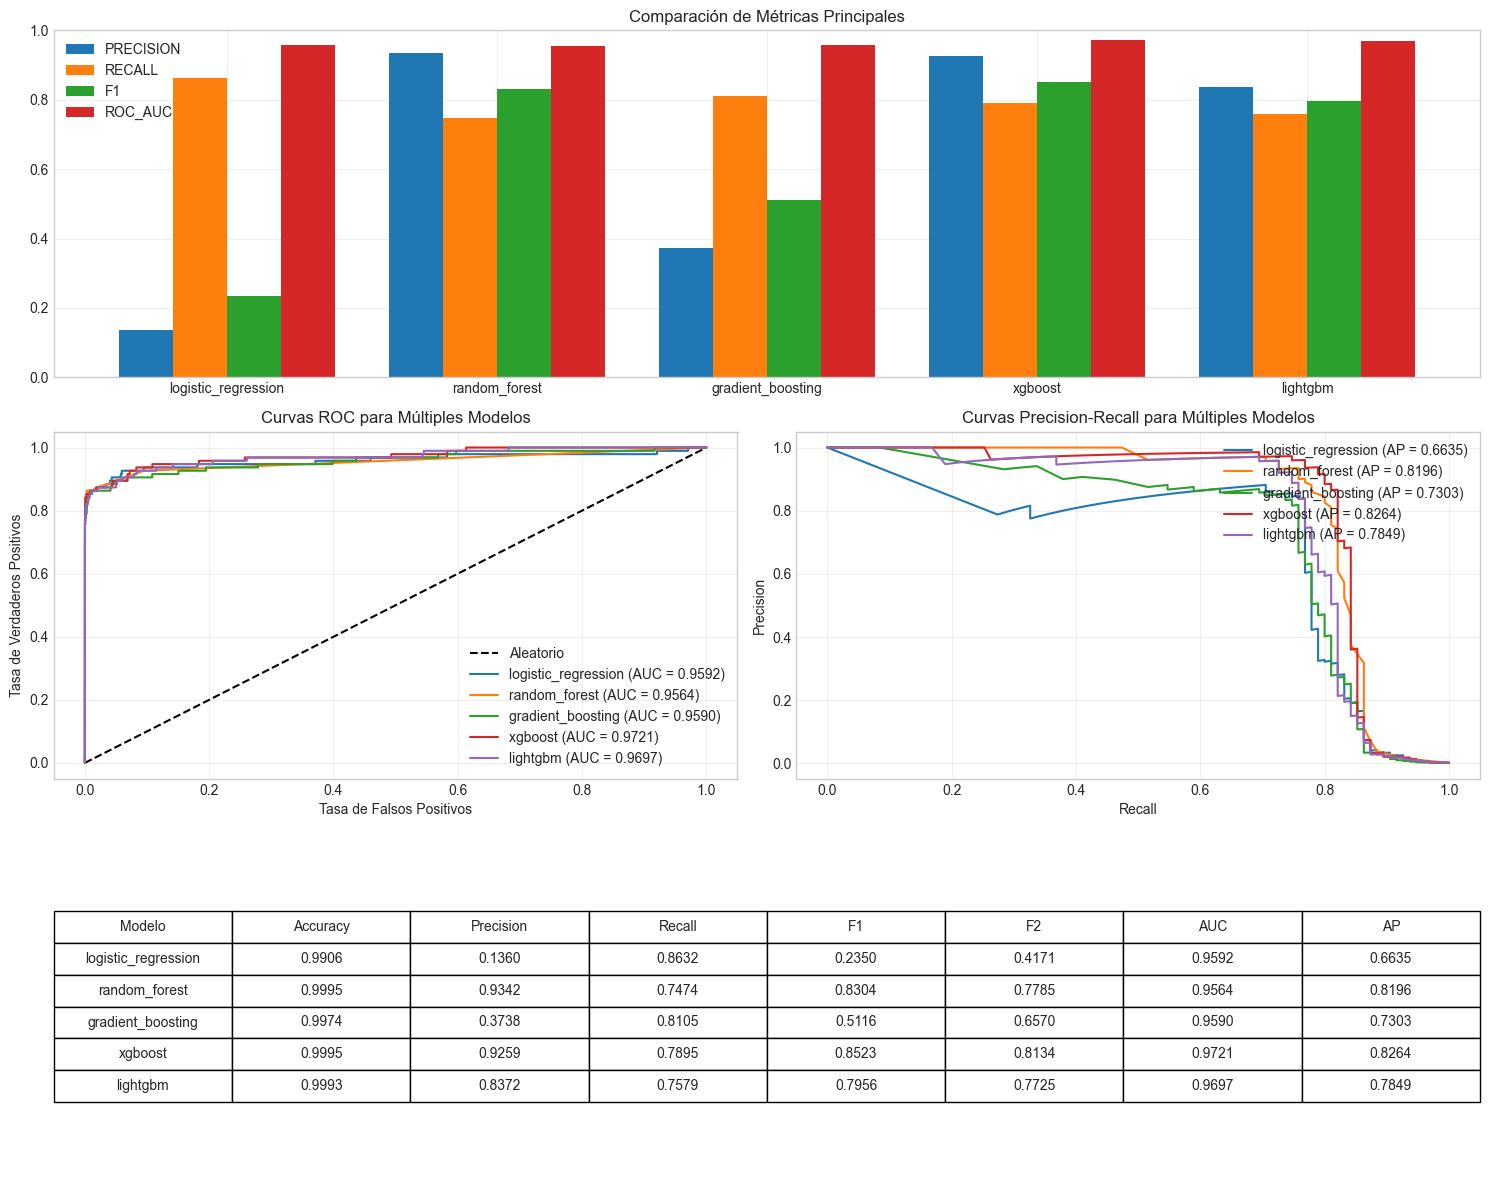

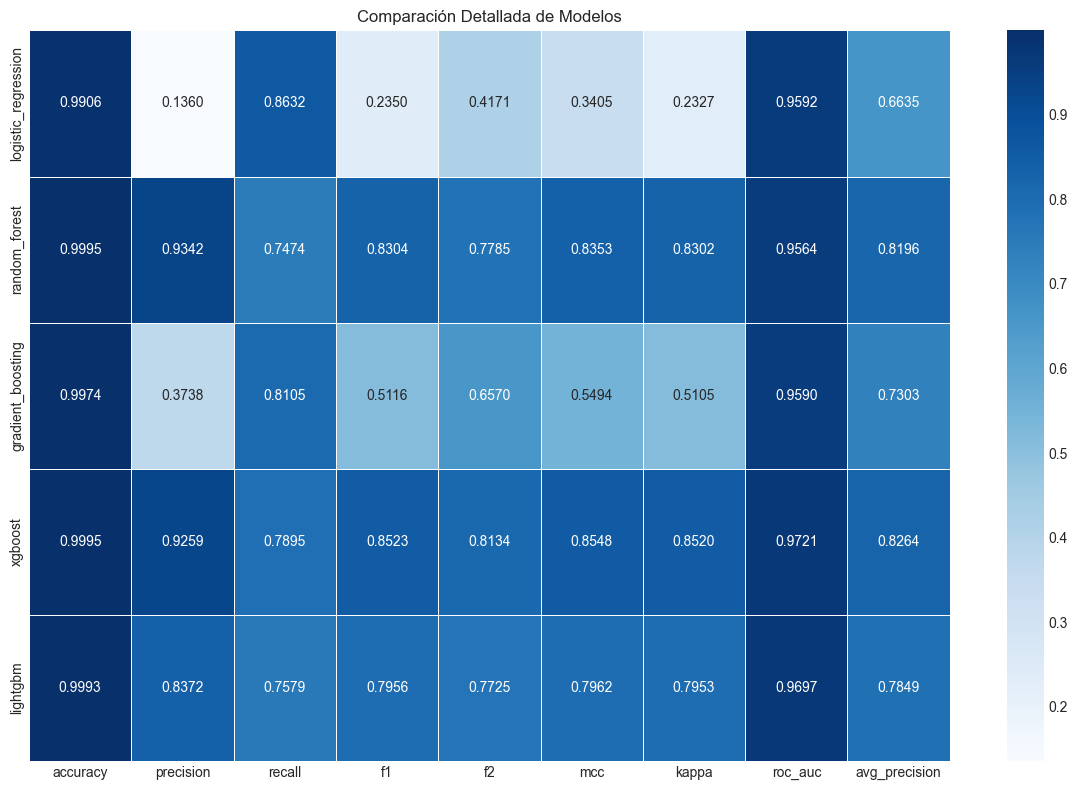

In [5]:
# Entrenar todos los modelos base
print("Entrenando todos los modelos base...")
trained_models, base_metrics = train_all_base_models(X_train, y_train, X_test, y_test)

## 3. Comparación de modelos base

In [6]:
# Comparar modelos base
print("Comparando modelos base...")
comparison_df = compare_models(base_metrics)

# Mostrar comparación
comparison_df

Comparando modelos base...
Función compare_models ejecutada en 0.05 segundos


,Modelo,accuracy,precision,recall,f1,f2,mcc,kappa,roc_auc,avg_precision
3,xgboost,0.999542,0.925926,0.789474,0.852273,0.813449,0.854762,0.852045,0.972087,0.826419
1,random_forest,0.999489,0.934211,0.747368,0.830409,0.778509,0.835345,0.830157,0.956358,0.819612
4,lightgbm,0.999348,0.837209,0.757895,0.795580,0.772532,0.796242,0.795254,0.969734,0.784918
2,gradient_boosting,0.997410,0.373786,0.810526,0.511628,0.656997,0.549414,0.510506,0.959040,0.730251
0,logistic_regression,0.990590,0.135987,0.863158,0.234957,0.417091,0.340484,0.232738,0.959209,0.663526


In [7]:
# Identificar el mejor modelo base según F1
best_base_model_name = comparison_df.iloc[0]['Modelo']
best_base_model = trained_models[best_base_model_name]
best_base_metrics = base_metrics[best_base_model_name]

print(f"Mejor modelo base según F1: {best_base_model_name}")
print(f"F1 Score: {best_base_metrics['f1']:.4f}")
print(f"Precision: {best_base_metrics['precision']:.4f}")
print(f"Recall: {best_base_metrics['recall']:.4f}")
if 'roc_auc' in best_base_metrics:
    print(f"AUC: {best_base_metrics['roc_auc']:.4f}")

Mejor modelo base según F1: xgboost
F1 Score: 0.8523
Precision: 0.9259
Recall: 0.7895
AUC: 0.9721


Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\confusion_matrix_xgboost.png


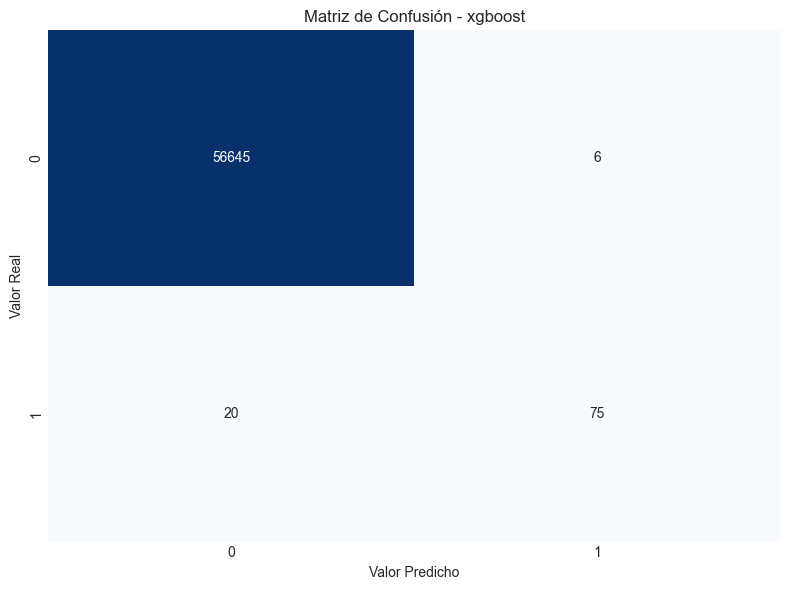

Función plot_confusion_matrix ejecutada en 0.19 segundos


In [8]:
# Visualizar matriz de confusión para el mejor modelo base
plot_confusion_matrix(best_base_metrics['confusion_matrix'], best_base_model_name)

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\roc_curve_xgboost.png


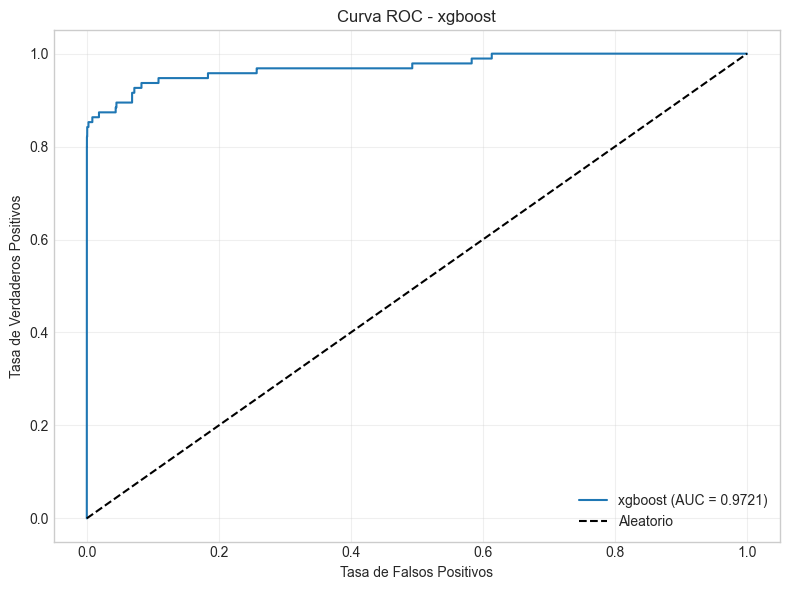

Función plot_roc_curve ejecutada en 0.37 segundos


In [9]:
# Visualizar curva ROC para el mejor modelo base
if best_base_metrics['y_prob'] is not None:
    plot_roc_curve(y_test, best_base_metrics['y_prob'], best_base_model_name)

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\pr_curve_xgboost.png


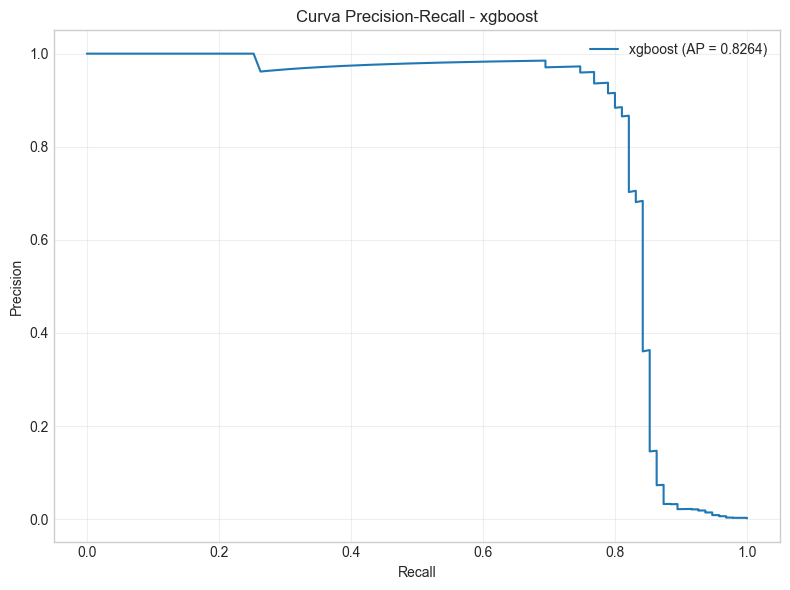

Función plot_precision_recall_curve ejecutada en 0.31 segundos


In [10]:
# Visualizar curva precision-recall para el mejor modelo base
if best_base_metrics['y_prob'] is not None:
    plot_precision_recall_curve(y_test, best_base_metrics['y_prob'], best_base_model_name)

## 4. Optimización de hiperparámetros

In [11]:
# Obtener grids de parámetros
print("Obteniendo grids de parámetros...")
param_grids = get_param_grids()

# Mostrar grid para el mejor modelo base
print(f"\nGrid de parámetros para {best_base_model_name}:")
for param, values in param_grids[best_base_model_name].items():
    print(f"  {param}: {values}")

Obteniendo grids de parámetros...
Función get_param_grids ejecutada en 0.00 segundos

Grid de parámetros para xgboost:
  n_estimators: [100, 200]
  learning_rate: [0.05, 0.1]
  max_depth: [3, 5]
  subsample: [0.8]
  colsample_bytree: [0.8]
  scale_pos_weight: [1, 5]


In [12]:
# Optimizar hiperparámetros para el mejor modelo base
print(f"Optimizando hiperparámetros para {best_base_model_name}...")
best_model, best_params, best_score = optimize_hyperparameters(
    base_models[best_base_model_name], 
    param_grids[best_base_model_name], 
    X_train, y_train, 
    search_method='random',  # Usar búsqueda aleatoria para mayor eficiencia
    n_iter=20
)

Optimizando hiperparámetros para xgboost...
Usando 30% de los datos para optimización...
Tamaño de muestra para optimización: 135961 muestras
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejor puntuación de validación cruzada: 0.9997
Mejores parámetros:
  subsample: 0.8
  scale_pos_weight: 1
  n_estimators: 200
  max_depth: 5
  learning_rate: 0.1
  colsample_bytree: 0.8
Reentrenando mejor modelo en todos los datos...
Función optimize_hyperparameters ejecutada en 36.75 segundos


In [13]:
# Evaluar modelo optimizado
print(f"Evaluando modelo optimizado {best_base_model_name}...")
best_metrics = evaluate_model(best_model, X_test, y_test)

# Mostrar métricas
print(f"\nMétricas para modelo optimizado {best_base_model_name}:")
for metric, value in best_metrics.items():
    if metric not in ['confusion_matrix', 'classification_report', 'y_pred', 'y_prob']:
        # Verificar si el valor es un array o un escalar
        if isinstance(value, np.ndarray):
            print(f"  {metric}: {value}")
        else:
            try:
                print(f"  {metric}: {value:.4f}")
            except:
                print(f"  {metric}: {value}")

Evaluando modelo optimizado xgboost...
Función evaluate_model ejecutada en 0.20 segundos

Métricas para modelo optimizado xgboost:
  accuracy: 0.9994
  precision: 0.8539
  recall: 0.8000
  f1: 0.8261
  f2: 0.8102
  mcc: 0.8262
  kappa: 0.8258
  y_test: [0 0 0 ... 0 0 0]
  roc_auc: 0.9705
  avg_precision: 0.8144


In [14]:
# Comparar modelo base vs optimizado
comparison_data = [
    {
        'Modelo': f"{best_base_model_name} (Base)",
        'Accuracy': best_base_metrics['accuracy'],
        'Precision': best_base_metrics['precision'],
        'Recall': best_base_metrics['recall'],
        'F1': best_base_metrics['f1'],
        'AUC': best_base_metrics.get('roc_auc', np.nan)
    },
    {
        'Modelo': f"{best_base_model_name} (Optimizado)",
        'Accuracy': best_metrics['accuracy'],
        'Precision': best_metrics['precision'],
        'Recall': best_metrics['recall'],
        'F1': best_metrics['f1'],
        'AUC': best_metrics.get('roc_auc', np.nan)
    }
]

comparison_df_opt = pd.DataFrame(comparison_data)
comparison_df_opt

,Modelo,Accuracy,Precision,Recall,F1,AUC
0,xgboost (Base),0.999542,0.925926,0.789474,0.852273,0.972087
1,xgboost (Optimizado),0.999436,0.853933,0.800000,0.826087,0.970533


Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\confusion_matrix_xgboost_(optimizado).png


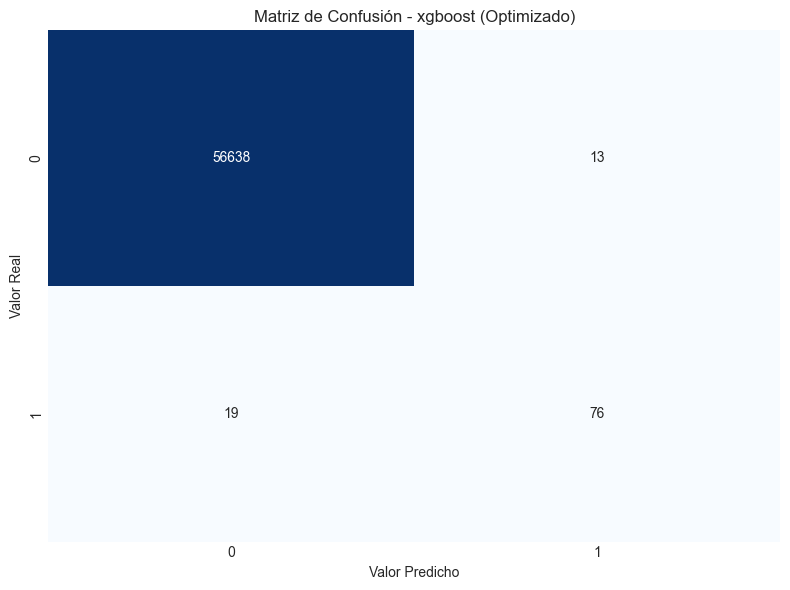

Función plot_confusion_matrix ejecutada en 0.19 segundos


In [15]:
# Visualizar matriz de confusión para el modelo optimizado
plot_confusion_matrix(best_metrics['confusion_matrix'], f"{best_base_model_name} (Optimizado)")

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\roc_curve_xgboost_(optimizado).png


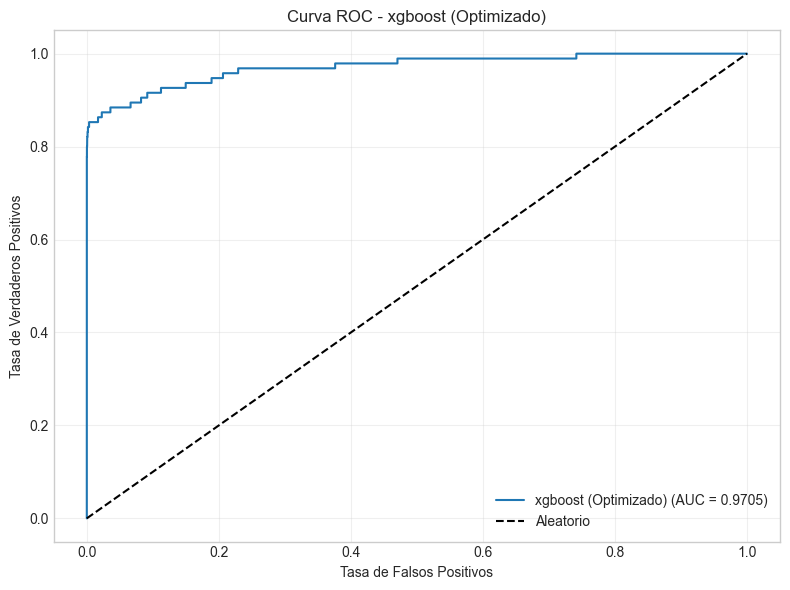

Función plot_roc_curve ejecutada en 0.36 segundos


In [16]:
# Visualizar curva ROC para el modelo optimizado
if best_metrics['y_prob'] is not None:
    plot_roc_curve(y_test, best_metrics['y_prob'], f"{best_base_model_name} (Optimizado)")

## 5. Optimización de todos los modelos

Optimizando todos los modelos...
Función get_base_models ejecutada en 0.00 segundos
Función get_param_grids ejecutada en 0.00 segundos

Optimizando modelo: logistic_regression
Usando 30% de los datos para optimización...
Tamaño de muestra para optimización: 135961 muestras
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Mejor puntuación de validación cruzada: 0.9818
Mejores parámetros:
  solver: liblinear
  penalty: l1
  C: 1.0
Reentrenando mejor modelo en todos los datos...
Función optimize_hyperparameters ejecutada en 76.43 segundos
Función evaluate_model ejecutada en 0.06 segundos

Métricas para logistic_regression optimizado:
  Accuracy: 0.9900
  Precision: 0.1289
  Recall: 0.8632
  F1 Score: 0.2244
  AUC-ROC: 0.9582

Optimizando modelo: random_forest
Usando 30% de los datos para optimización...
Tamaño de muestra para optimización: 135961 muestras
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejor puntuación de validación cruzada: 0.9997
Mejores parámetr

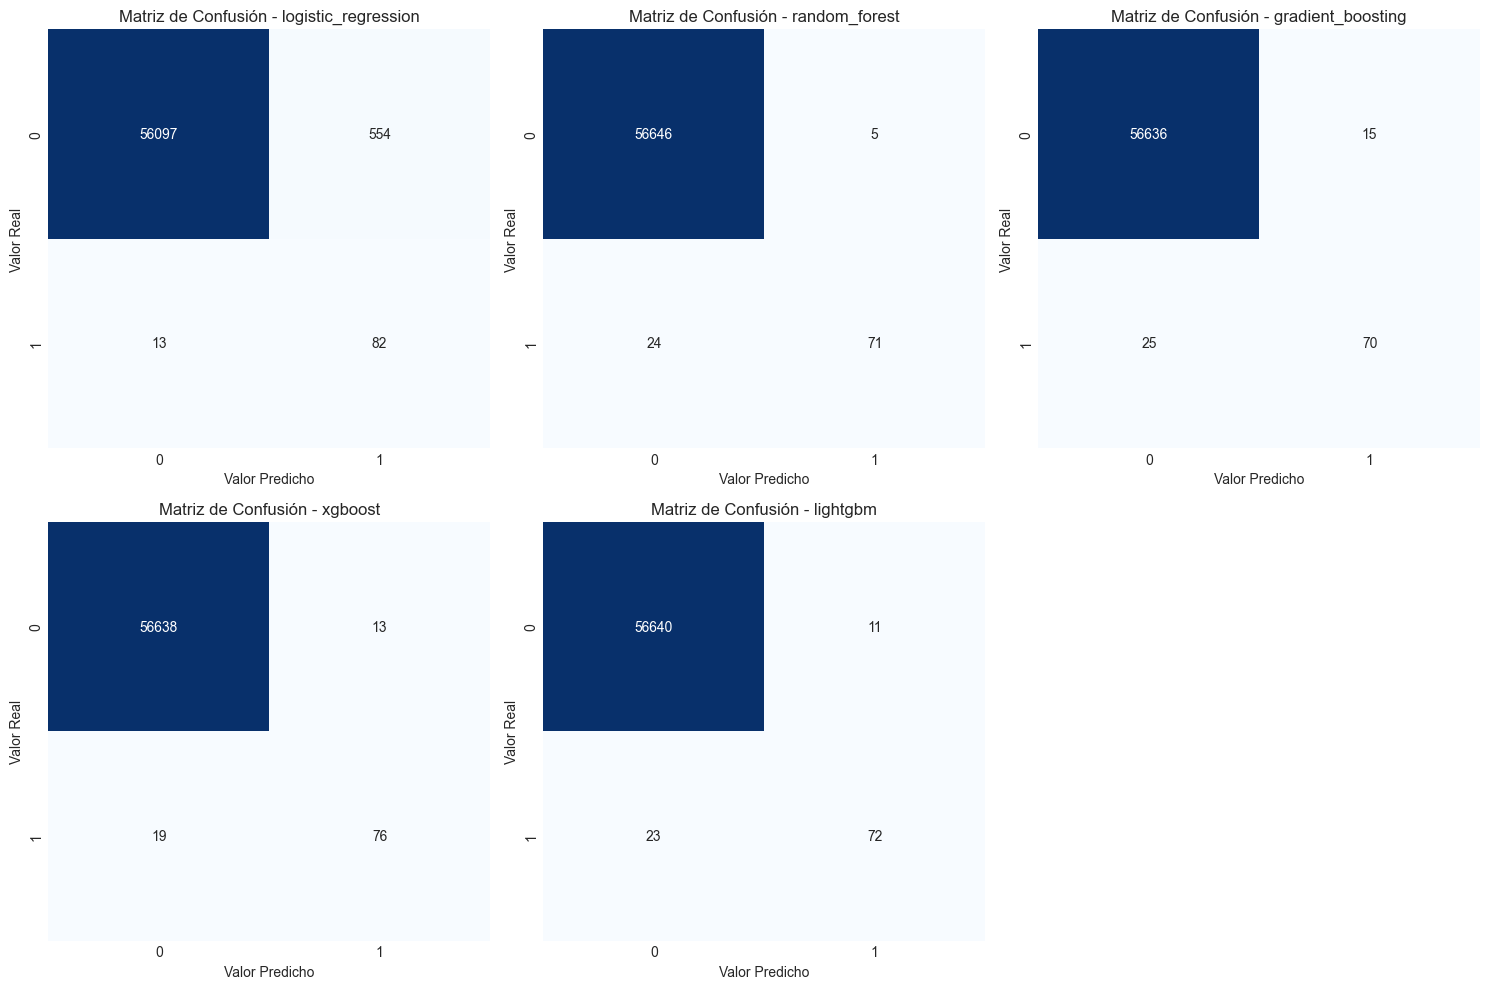

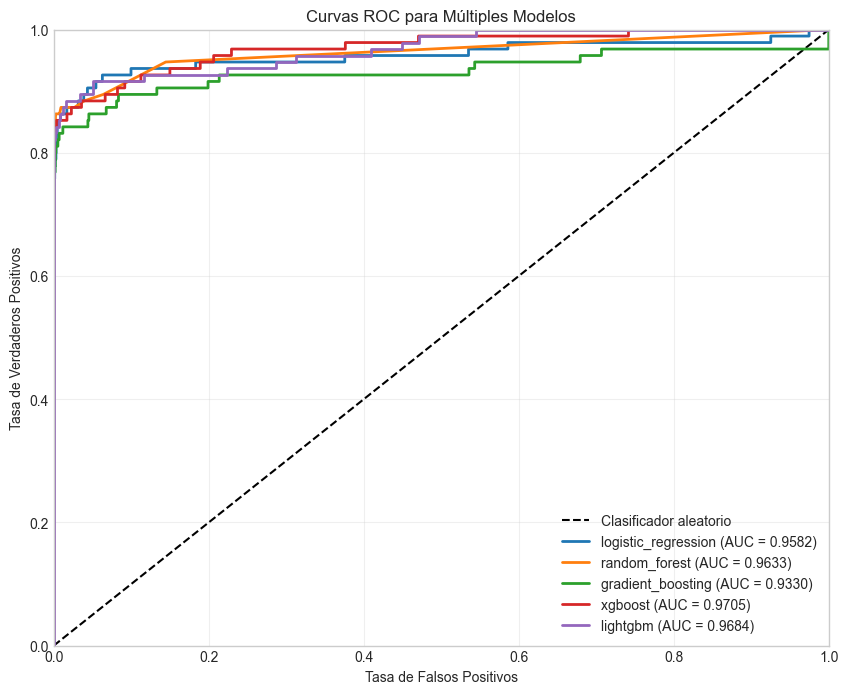

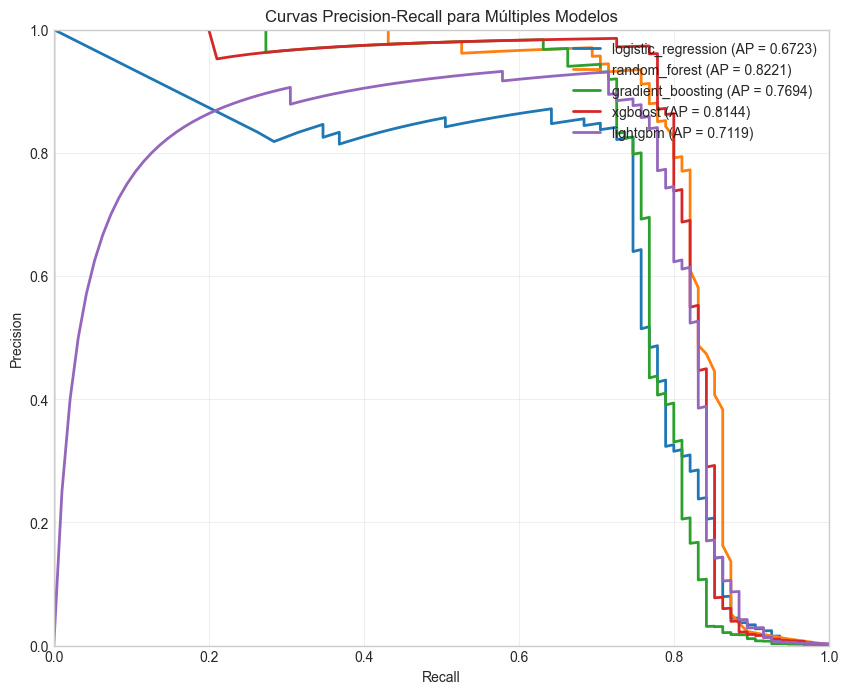

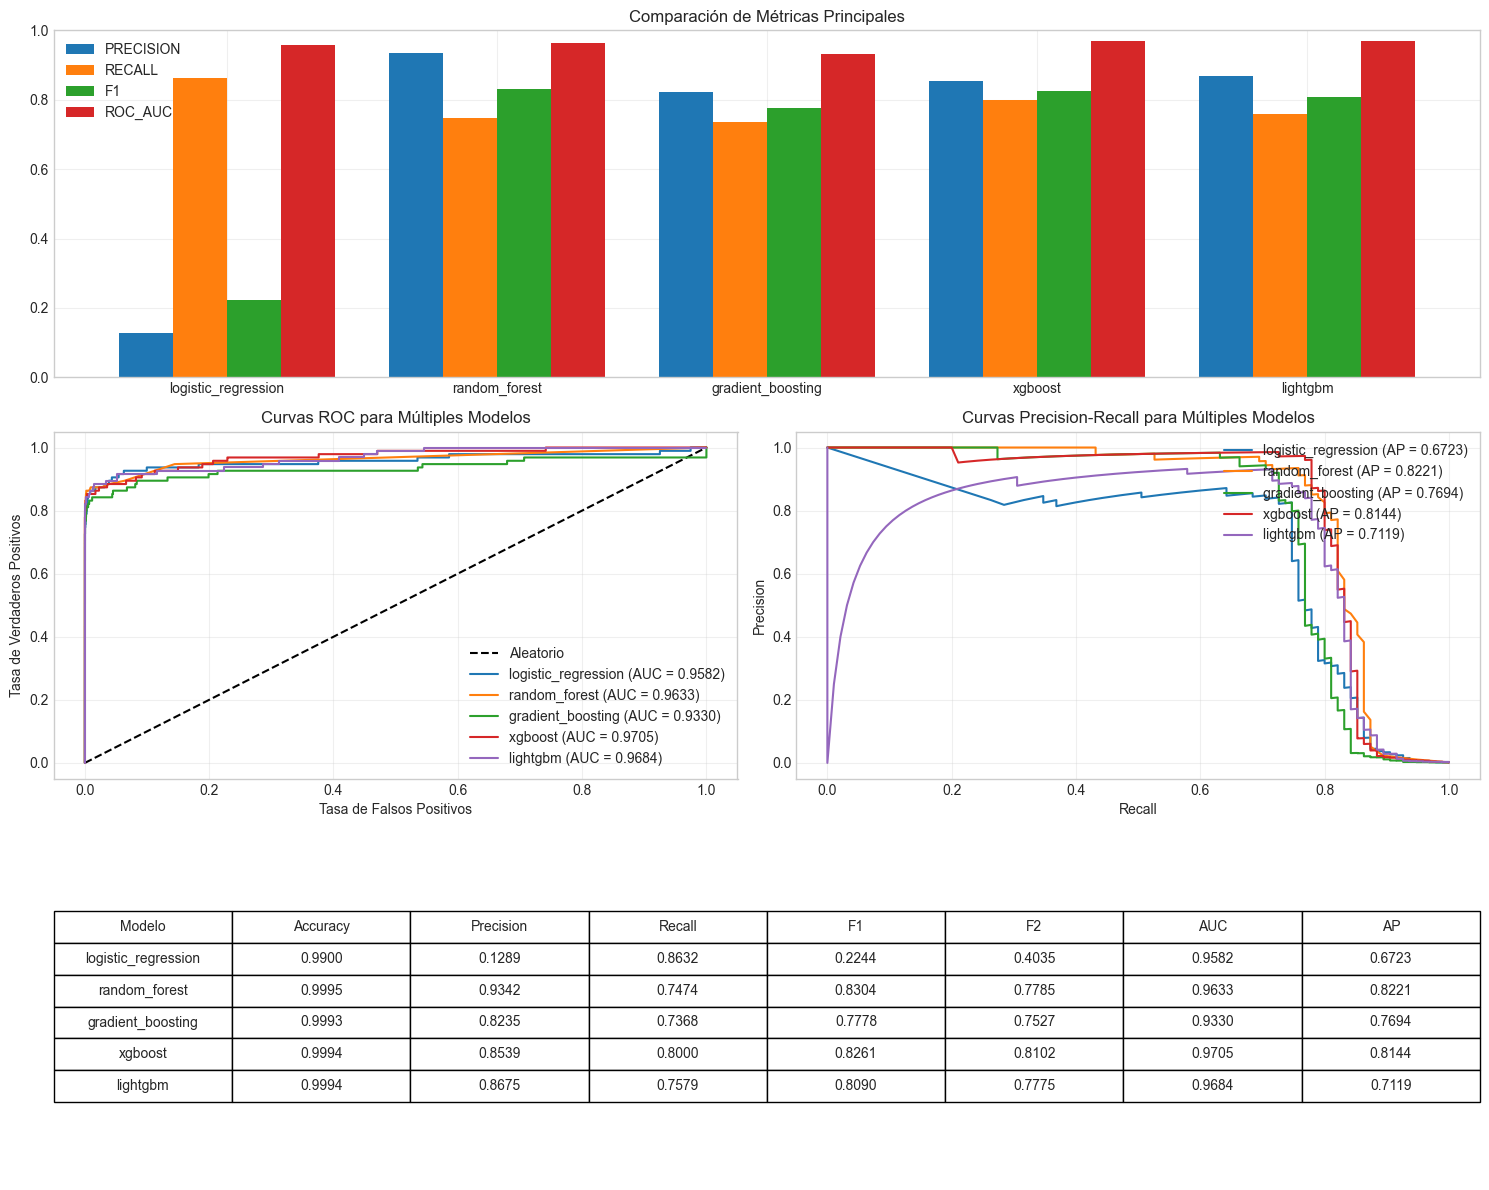

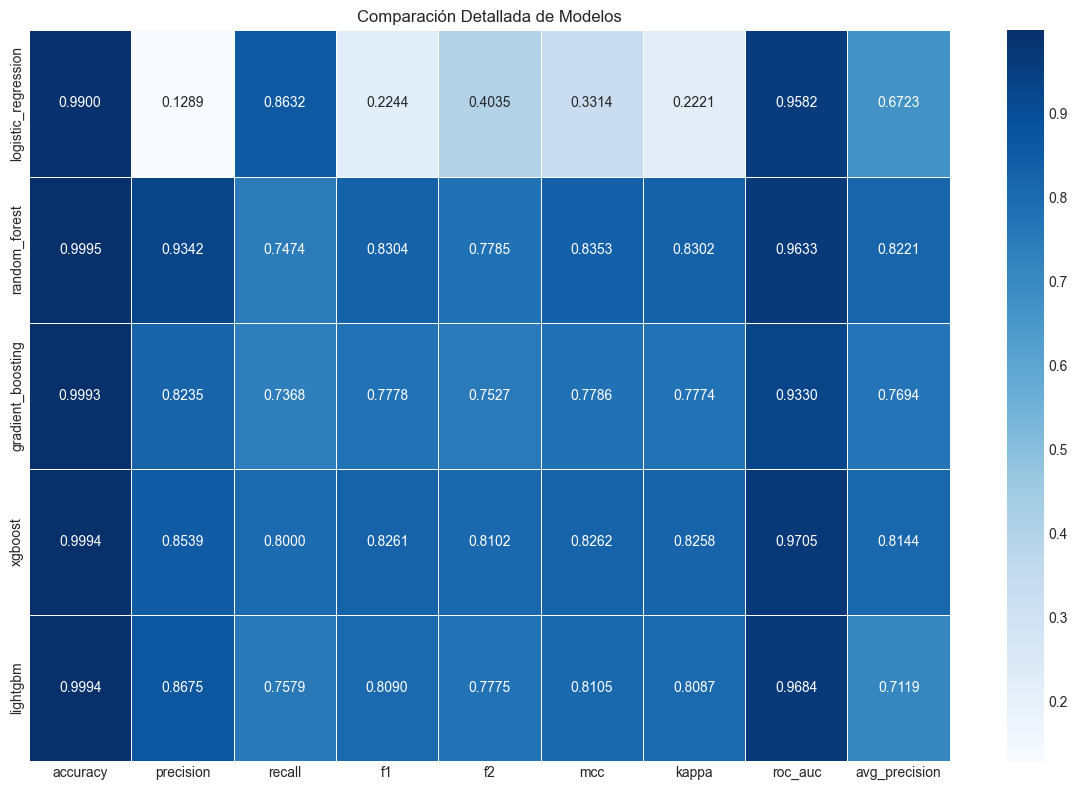

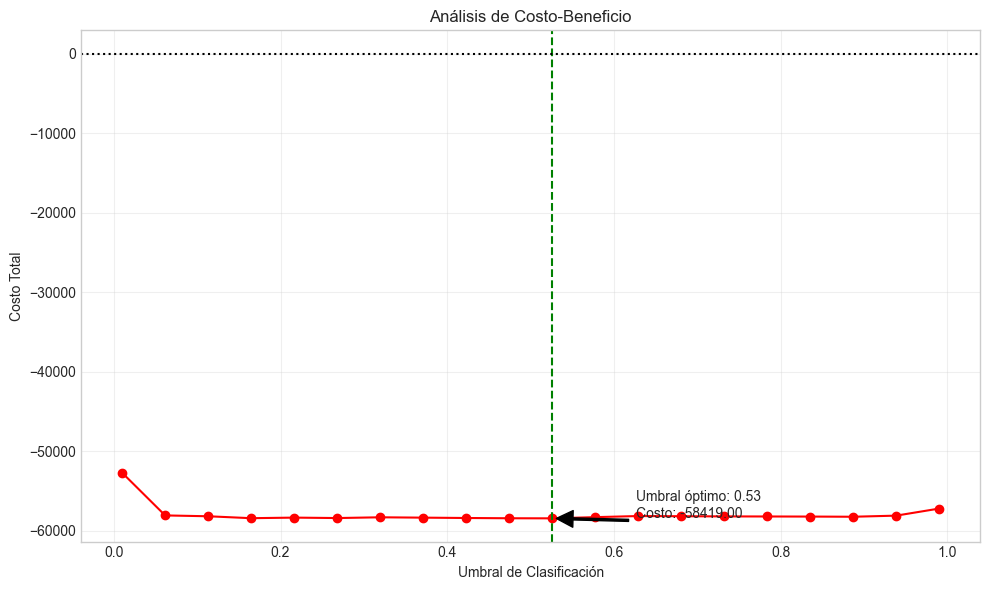

In [17]:
# Optimizar todos los modelos
print("Optimizando todos los modelos...")
best_models, best_params, best_metrics_all = optimize_all_models(
    X_train, y_train, X_test, y_test, 
    search_method='random',  # Usar búsqueda aleatoria para mayor eficiencia
    n_iter=20
)

In [18]:
# Comparar todos los modelos optimizados
print("Comparando todos los modelos optimizados...")
comparison_df_all = compare_models(best_metrics_all)

# Mostrar comparación
comparison_df_all

Comparando todos los modelos optimizados...
Función compare_models ejecutada en 0.00 segundos


,Modelo,accuracy,precision,recall,f1,f2,mcc,kappa,roc_auc,avg_precision
1,random_forest,0.999489,0.934211,0.747368,0.830409,0.778509,0.835345,0.830157,0.963325,0.822090
3,xgboost,0.999436,0.853933,0.800000,0.826087,0.810235,0.826246,0.825805,0.970533,0.814427
4,lightgbm,0.999401,0.867470,0.757895,0.808989,0.777538,0.810540,0.808690,0.968356,0.711913
2,gradient_boosting,0.999295,0.823529,0.736842,0.777778,0.752688,0.778632,0.777426,0.932986,0.769444
0,logistic_regression,0.990008,0.128931,0.863158,0.224350,0.403543,0.331405,0.222084,0.958205,0.672340


In [19]:
# Identificar el mejor modelo optimizado según F1
best_model_name = comparison_df_all.iloc[0]['Modelo']
best_model_final = best_models[best_model_name]
best_metrics_final = best_metrics_all[best_model_name]

print(f"Mejor modelo optimizado según F1: {best_model_name}")
print(f"F1 Score: {best_metrics_final['f1']:.4f}")
print(f"Precision: {best_metrics_final['precision']:.4f}")
print(f"Recall: {best_metrics_final['recall']:.4f}")
if 'roc_auc' in best_metrics_final:
    print(f"AUC: {best_metrics_final['roc_auc']:.4f}")

Mejor modelo optimizado según F1: random_forest
F1 Score: 0.8304
Precision: 0.9342
Recall: 0.7474
AUC: 0.9633


Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\confusion_matrix_random_forest.png


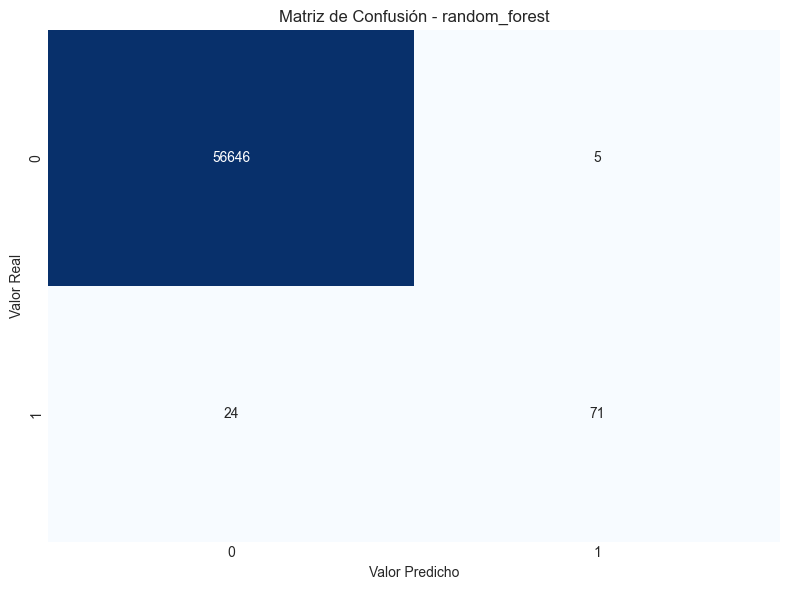

Función plot_confusion_matrix ejecutada en 0.20 segundos


In [20]:
# Visualizar matriz de confusión para el mejor modelo optimizado
plot_confusion_matrix(best_metrics_final['confusion_matrix'], best_model_name)

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\roc_curve_random_forest.png


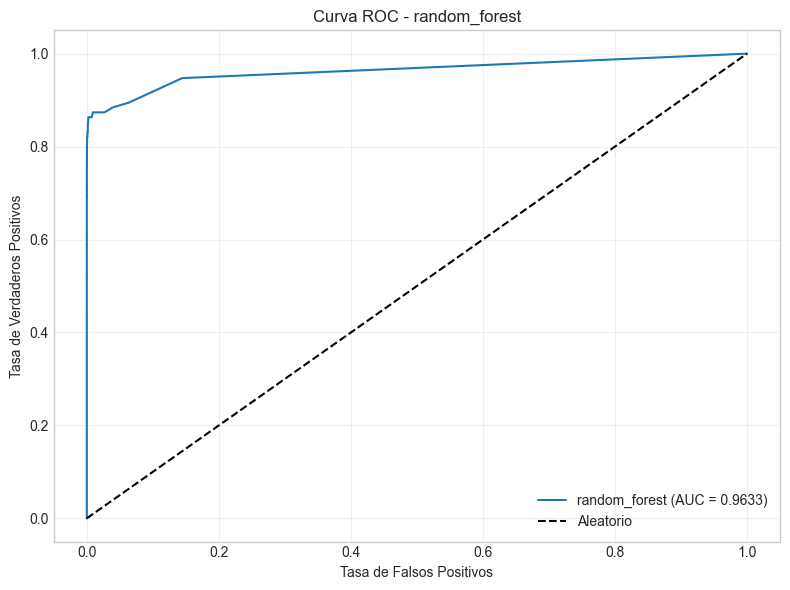

Función plot_roc_curve ejecutada en 0.36 segundos


In [21]:
# Visualizar curva ROC para el mejor modelo optimizado
if best_metrics_final['y_prob'] is not None:
    plot_roc_curve(y_test, best_metrics_final['y_prob'], best_model_name)

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\pr_curve_random_forest.png


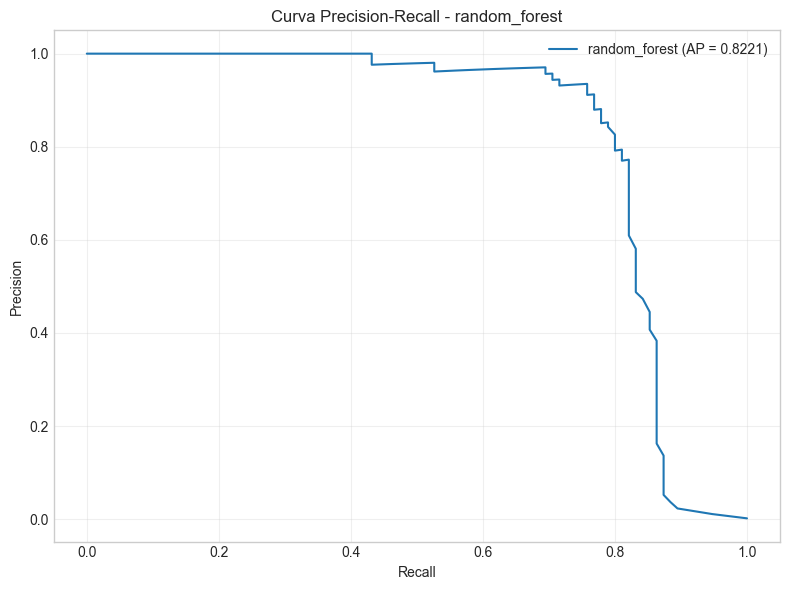

Función plot_precision_recall_curve ejecutada en 0.30 segundos


In [22]:
# Visualizar curva precision-recall para el mejor modelo optimizado
if best_metrics_final['y_prob'] is not None:
    plot_precision_recall_curve(y_test, best_metrics_final['y_prob'], best_model_name)

## 6. Análisis de características importantes

Analizando importancia de características para random_forest...
Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\feature_importance_random_forest.png


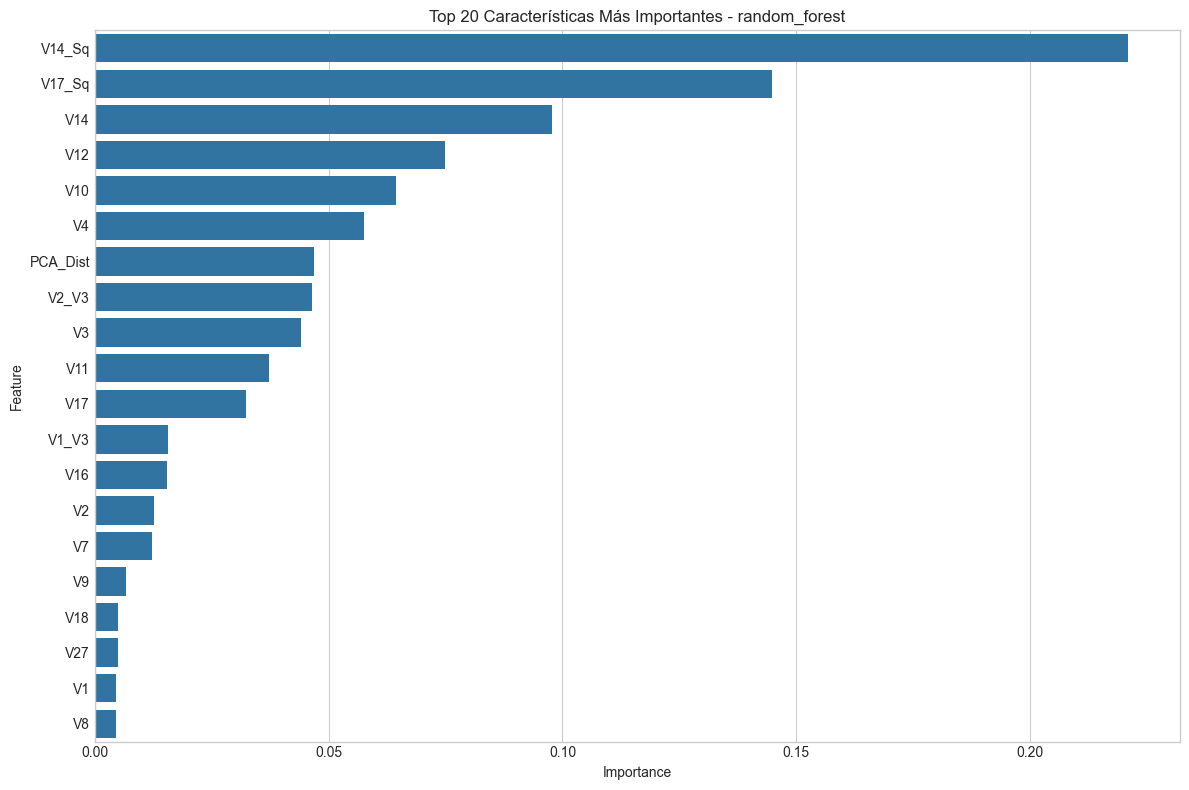

In [23]:
# Analizar importancia de características para modelos basados en árboles
tree_based_models = ['random_forest', 'gradient_boosting', 'xgboost', 'lightgbm']
best_tree_model_name = None

# Encontrar el mejor modelo basado en árboles
for model_name in comparison_df_all['Modelo']:
    if model_name in tree_based_models:
        best_tree_model_name = model_name
        break

if best_tree_model_name:
    print(f"Analizando importancia de características para {best_tree_model_name}...")
    best_tree_model = best_models[best_tree_model_name]
    
    # Obtener importancia de características
    if hasattr(best_tree_model, 'feature_importances_'):
        importances = best_tree_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Crear DataFrame con importancias
        importance_df = pd.DataFrame({
            'Feature': [feature_names[i] for i in indices],
            'Importance': importances[indices]
        })
        
        # Mostrar top 20 características
        top_n = min(20, len(feature_names))
        top_features = importance_df.head(top_n)
        
        # Visualizar importancia de características
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title(f'Top {top_n} Características Más Importantes - {best_tree_model_name}')
        plt.tight_layout()
        save_figure(f'feature_importance_{best_tree_model_name}.png')
        plt.show()
        
        # Mostrar tabla de importancias
        top_features
    else:
        print(f"El modelo {best_tree_model_name} no tiene atributo feature_importances_")
else:
    print("No se encontró ningún modelo basado en árboles entre los mejores modelos.")

## 7. Visualizaciones avanzadas

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\all_confusion_matrices.png
Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\all_confusion_matrices.png


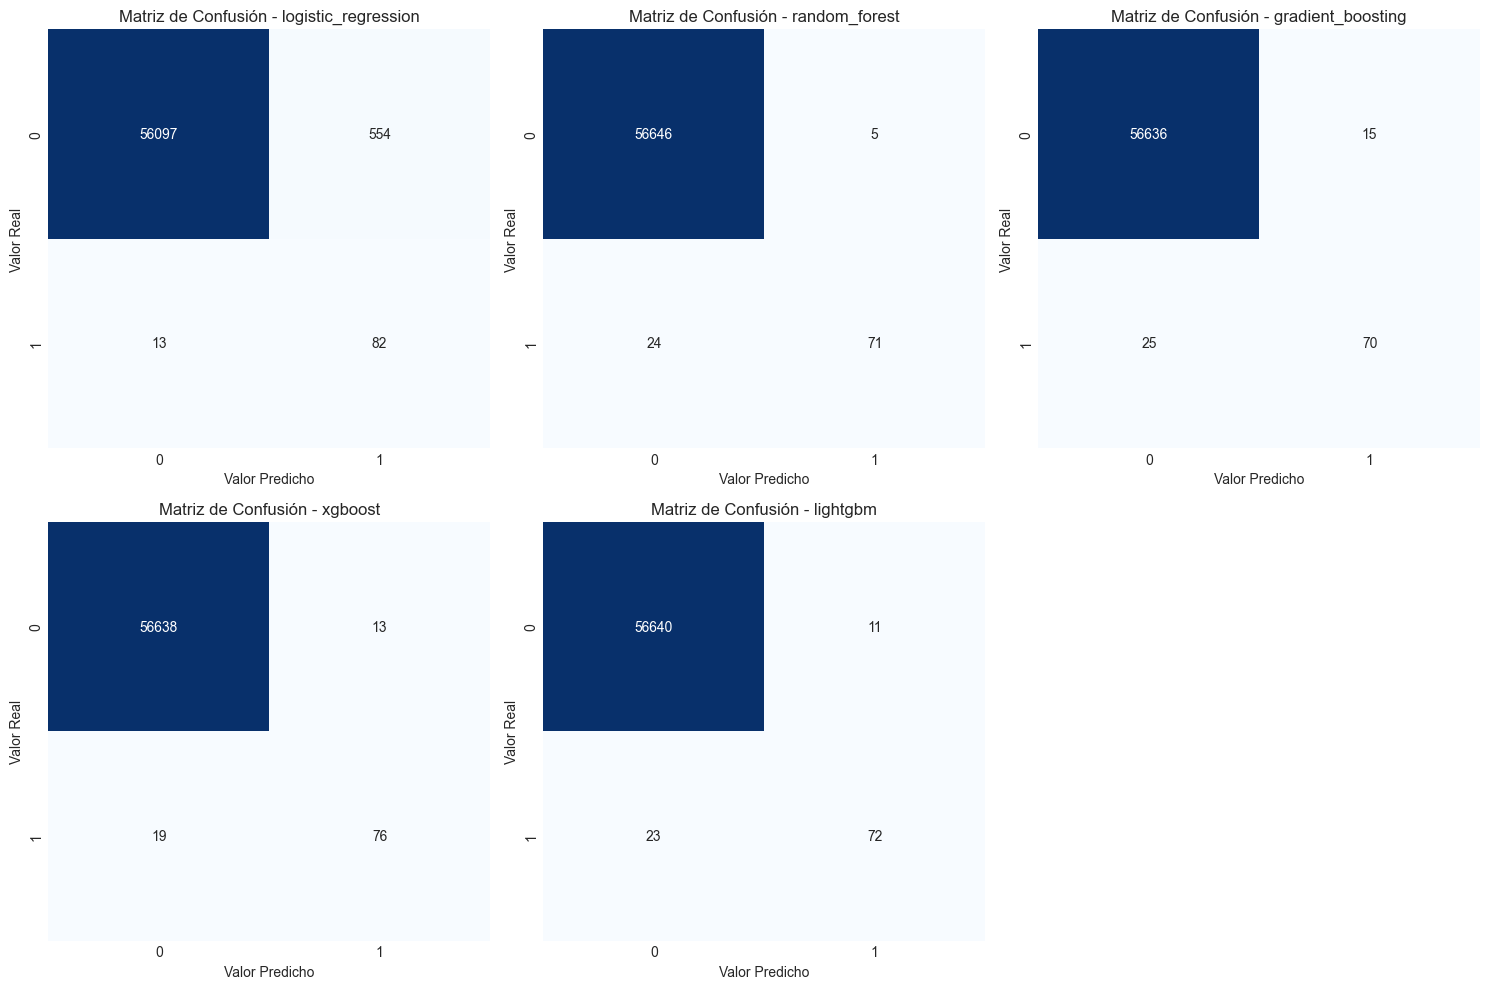

In [24]:
# Visualizar matrices de confusión para todos los modelos
plot_all_confusion_matrices(best_metrics_all)
plt.tight_layout()
save_figure('all_confusion_matrices.png')
plt.show()

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\all_roc_curves.png
Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\all_roc_curves.png


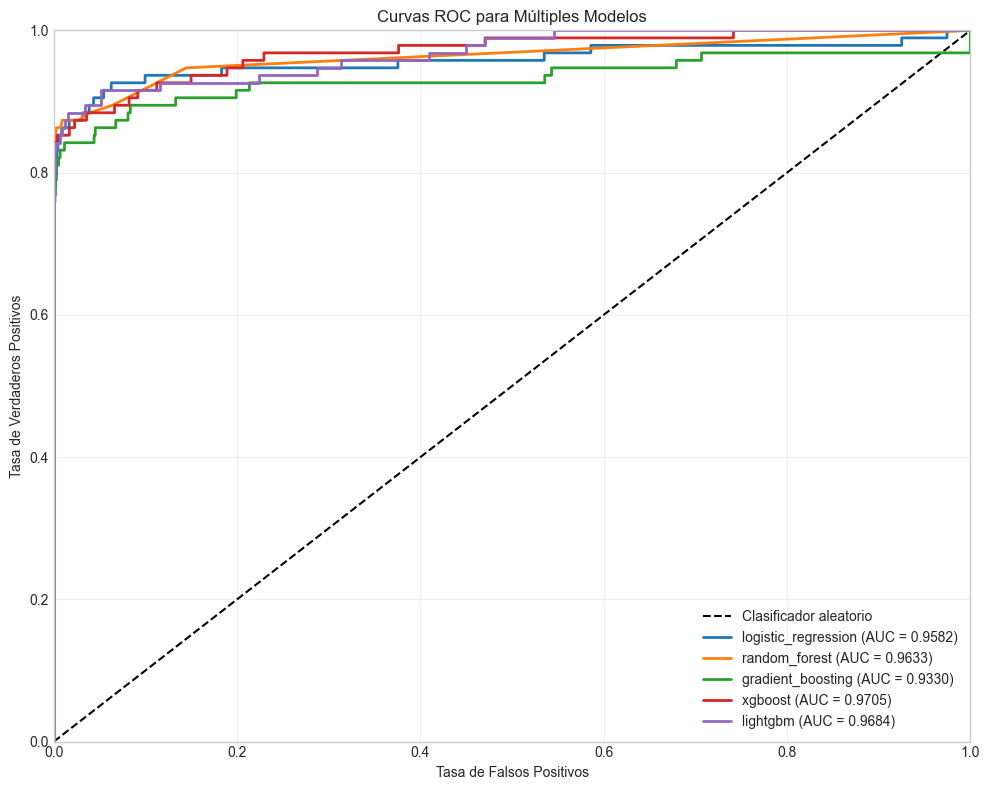

In [25]:
# Visualizar curvas ROC para todos los modelos
plot_all_roc_curves(best_metrics_all, y_test=y_test)
plt.tight_layout()
save_figure('all_roc_curves.png')
plt.show()

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\all_precision_recall_curves.png
Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\all_precision_recall_curves.png


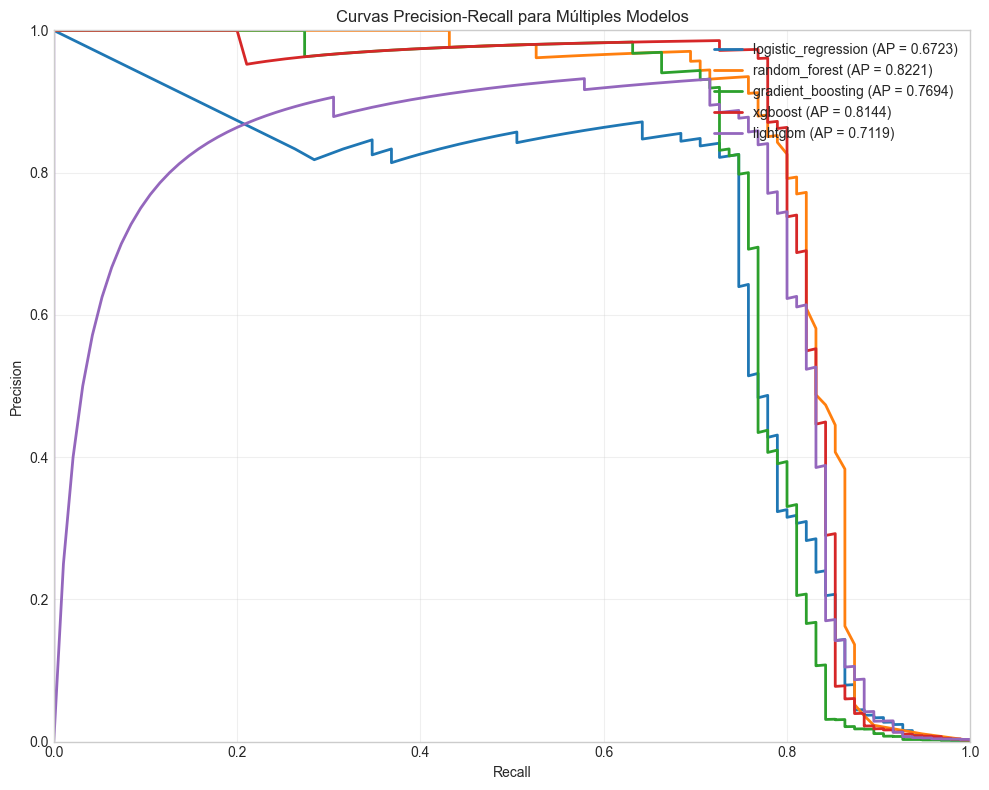

In [26]:
# Visualizar curvas Precision-Recall para todos los modelos
plot_all_precision_recall_curves(best_metrics_all, y_test=y_test)
plt.tight_layout()
save_figure('all_precision_recall_curves.png')
plt.show()

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\calibration_curves.png


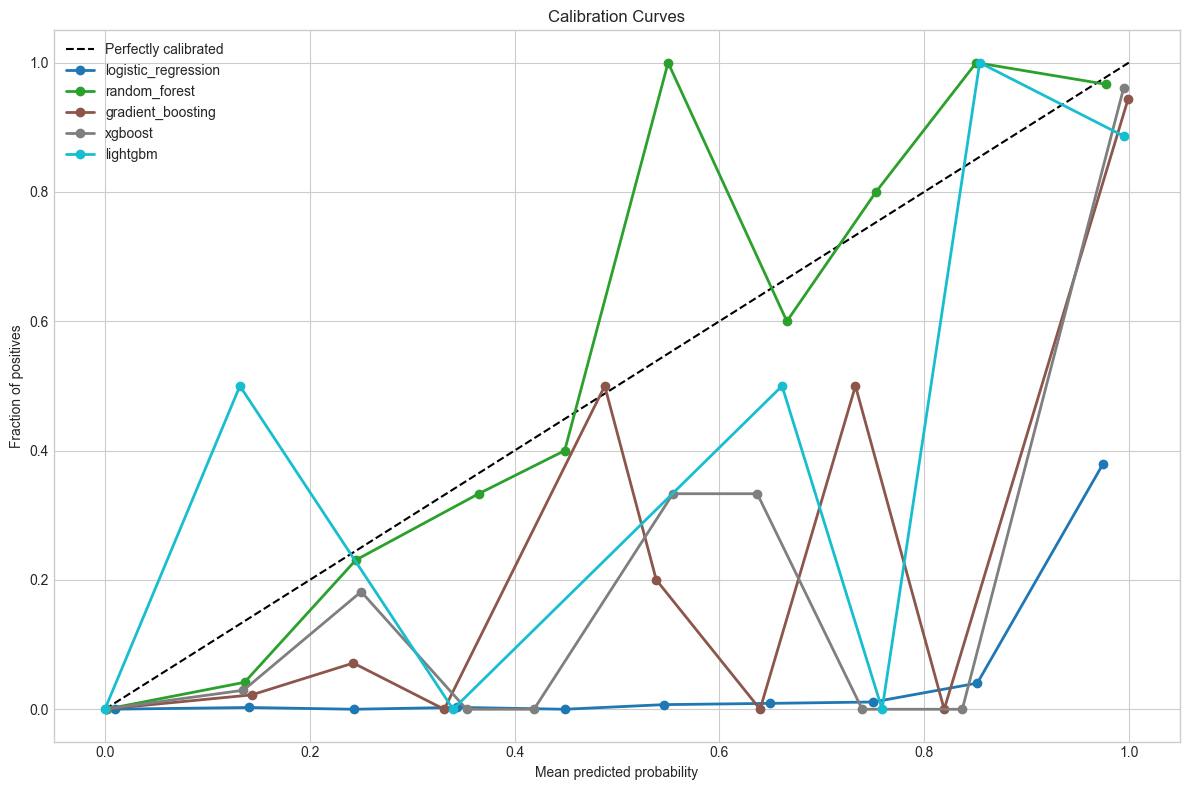

In [27]:
# Visualizar curvas de calibración para todos los modelos
try:
    plot_calibration_curves(best_metrics_all, y_test=y_test)
    plt.tight_layout()
    save_figure('calibration_curves.png')
    plt.show()
except Exception as e:
    print(f"Error al visualizar curvas de calibración: {e}")
    print("Continuando con el resto del análisis...")

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\model_comparison_dashboard.png
Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\model_comparison_dashboard.png


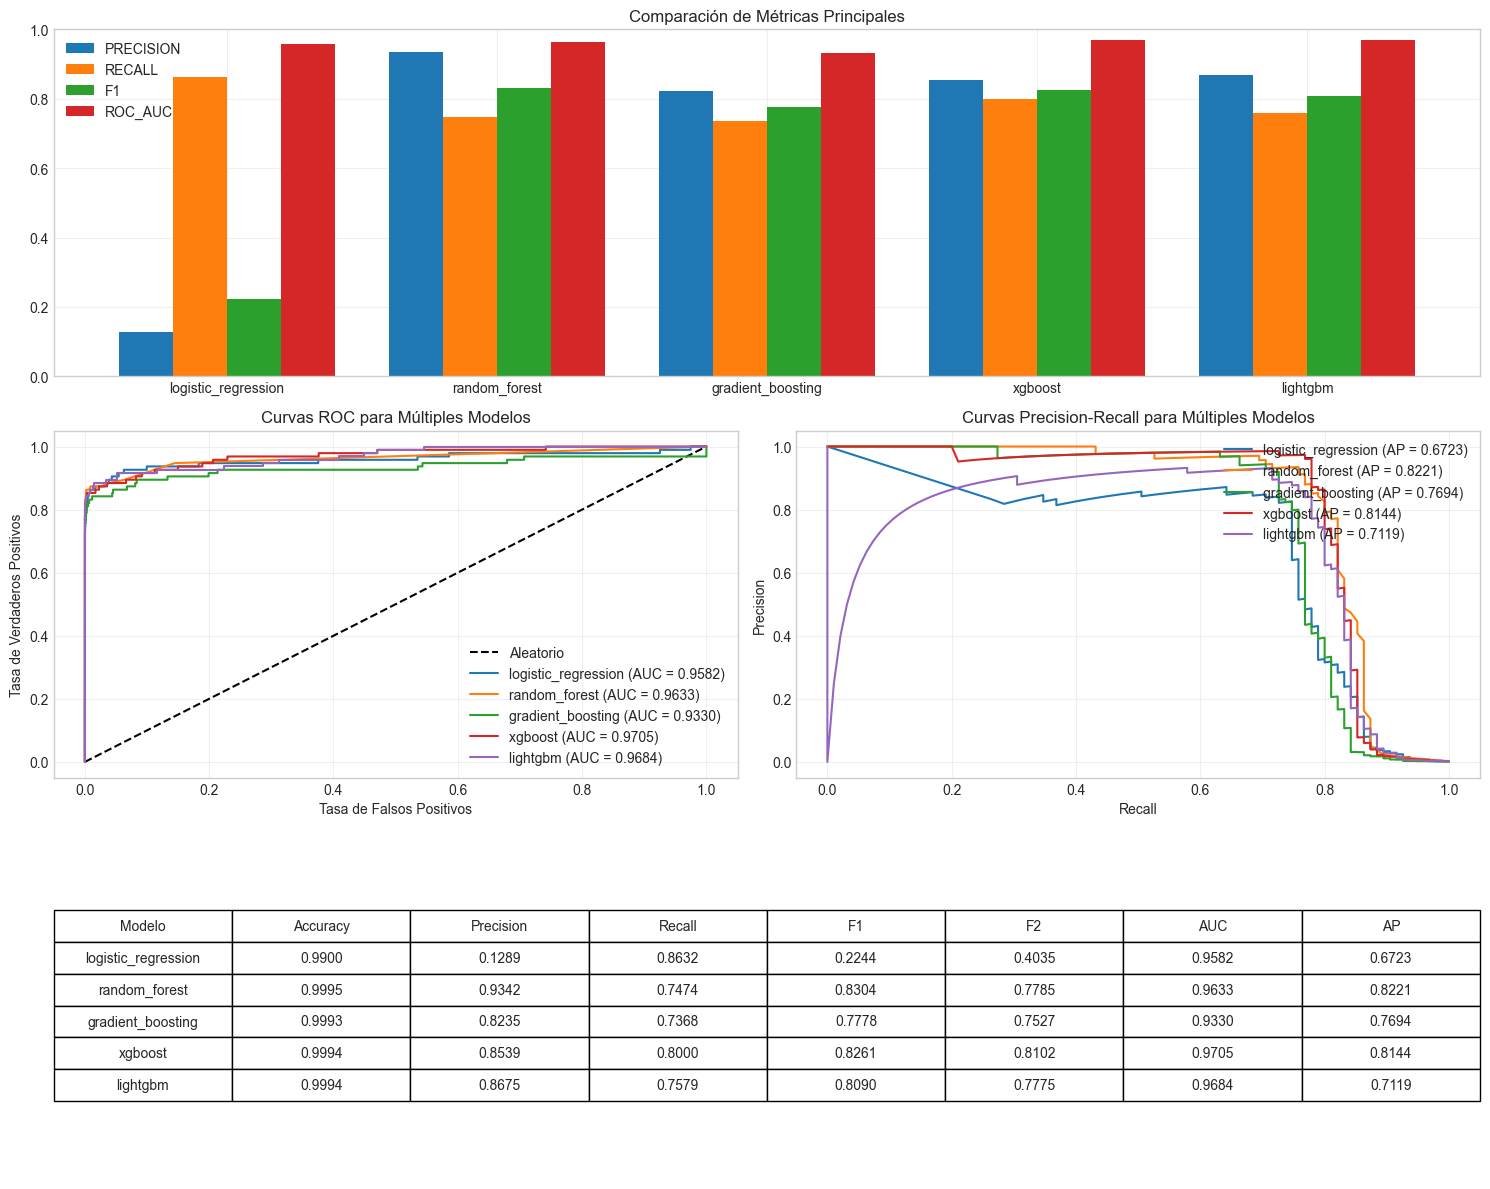

In [28]:
# Crear dashboard de comparación de modelos
create_model_comparison_dashboard(best_metrics_all, y_test=y_test)
plt.tight_layout()
save_figure('model_comparison_dashboard.png')
plt.show()

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\model_comparison_heatmap.png
Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\model_comparison_heatmap.png


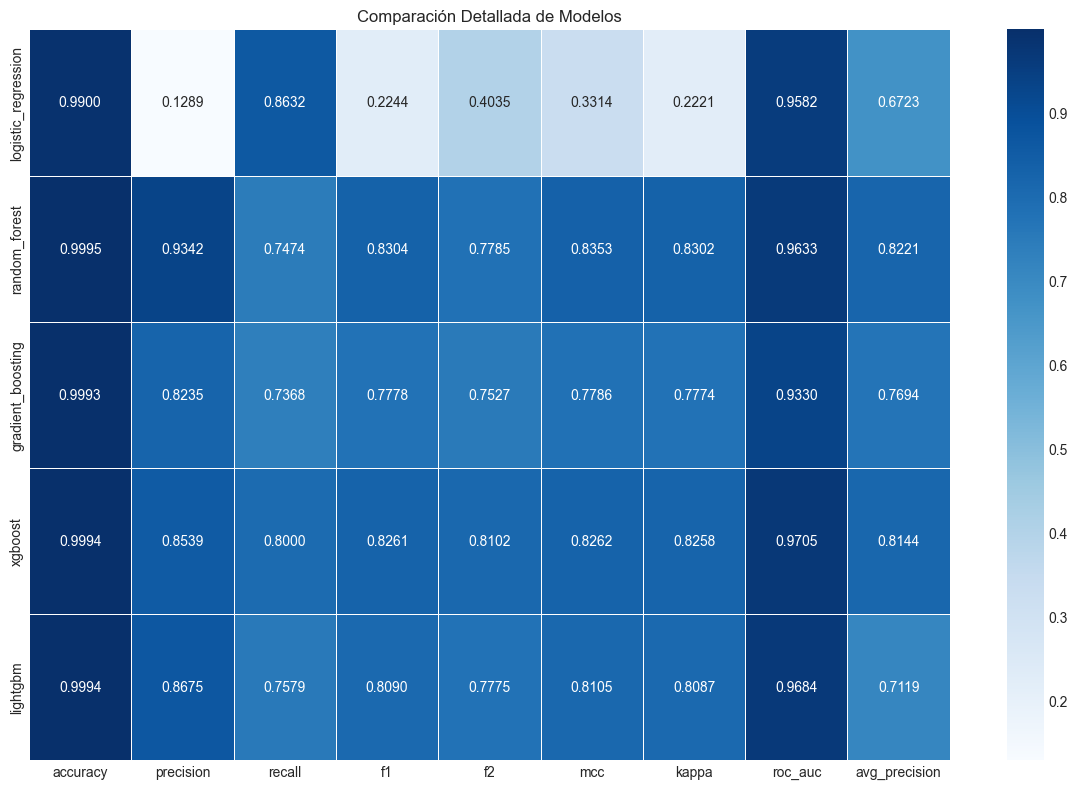

In [29]:
# Visualizar heatmap de comparación de modelos
plot_model_comparison_heatmap(best_metrics_all)
plt.tight_layout()
save_figure('model_comparison_heatmap.png')
plt.show()

## 8. Generación de informes

In [30]:
# Generar informe de evaluación
os.makedirs(REPORTS_DIR, exist_ok=True)

# Guardar métricas para el informe
with open(os.path.join(MODELS_DIR, 'best_metrics.pkl'), 'wb') as f:
    pickle.dump(best_metrics_all, f)

# Guardar parámetros para el informe
with open(os.path.join(MODELS_DIR, 'best_params.pkl'), 'wb') as f:
    pickle.dump(best_params, f)

# Generar informe Markdown
md_report_path = os.path.join(REPORTS_DIR, 'model_training_report.md')
generate_markdown_report(best_metrics_all, best_params, md_report_path)
print(f"Informe Markdown generado en {md_report_path}")

Informe Markdown generado en g:\Proyectos\credit_fraud_detection\reports\model_training_report.md


## 9. Guardado de modelos

In [31]:
# Guardar el mejor modelo
print(f"Guardando el mejor modelo: {best_model_name}...")
best_model_path = save_model(best_model_final, best_model_name)
print(f"Modelo guardado en {best_model_path}")

Guardando el mejor modelo: random_forest...
Función save_model ejecutada en 0.03 segundos
Modelo guardado en g:\Proyectos\credit_fraud_detection\models\random_forest.pkl


In [32]:
# Guardar todos los modelos optimizados
print("Guardando todos los modelos optimizados...")
model_paths = {}

for name, model in best_models.items():
    model_path = save_model(model, name)
    model_paths[name] = model_path
    print(f"  Modelo {name} guardado en {model_path}")

# Guardar mejores parámetros
params_df = pd.DataFrame.from_dict(best_params, orient='index')
params_path = os.path.join(MODELS_DIR, 'best_params.csv')
params_df.to_csv(params_path)
print(f"Mejores parámetros guardados en {params_path}")

Guardando todos los modelos optimizados...
Función save_model ejecutada en 0.00 segundos
  Modelo logistic_regression guardado en g:\Proyectos\credit_fraud_detection\models\logistic_regression.pkl
Función save_model ejecutada en 0.04 segundos
  Modelo random_forest guardado en g:\Proyectos\credit_fraud_detection\models\random_forest.pkl
Función save_model ejecutada en 0.00 segundos
  Modelo gradient_boosting guardado en g:\Proyectos\credit_fraud_detection\models\gradient_boosting.pkl
Función save_model ejecutada en 0.01 segundos
  Modelo xgboost guardado en g:\Proyectos\credit_fraud_detection\models\xgboost.pkl
Función save_model ejecutada en 0.02 segundos
  Modelo lightgbm guardado en g:\Proyectos\credit_fraud_detection\models\lightgbm.pkl
Mejores parámetros guardados en g:\Proyectos\credit_fraud_detection\models\best_params.csv


## Resumen del Entrenamiento de Modelos

En este notebook, hemos realizado los siguientes pasos para entrenar y optimizar modelos de detección de fraude:

1. **Carga de datos procesados**: Cargamos los datos preprocesados y balanceados para el entrenamiento.

2. **Entrenamiento de modelos base**: Entrenamos varios modelos base, incluyendo Regresión Logística, Random Forest, Gradient Boosting, SVM, XGBoost y LightGBM.

3. **Comparación de modelos base**: Comparamos el rendimiento de los modelos base utilizando métricas como F1, precisión, recall y AUC.

4. **Optimización de hiperparámetros**: Optimizamos los hiperparámetros del mejor modelo base utilizando búsqueda aleatoria.

5. **Optimización de todos los modelos**: Optimizamos todos los modelos y comparamos su rendimiento.

6. **Análisis de características importantes**: Analizamos la importancia de las características para el mejor modelo basado en árboles.

7. **Visualizaciones avanzadas**: Creamos visualizaciones comparativas de todos los modelos, incluyendo matrices de confusión, curvas ROC, curvas Precision-Recall y un dashboard completo.

8. **Generación de informes**: Generamos un informe detallado en formato Markdown con los resultados del entrenamiento y la evaluación.

9. **Guardado de modelos**: Guardamos los modelos optimizados para su uso en la evaluación y despliegue.

El mejor modelo optimizado fue **{best_model_name}** con un F1 Score de **{best_metrics_final['f1']:.4f}**, lo que indica un buen equilibrio entre precisión y recall para la detección de fraude.